In [1]:
# ## install finrl library
import os
print(os.getcwd())
! pip install wrds
! pip install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
! pip install -r requirements.txt

c:\Users\ThinkPad\Desktop\code\FinRL


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

# %matplotlib inline
from finrl.config_tickers import DOW_30_TICKER, SSE_50_TICKER, CRYPTO_TICKERS, FX_TICKER, HSI_50_TICKER,NAS_100_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")
import itertools
DATASET = {'DOW_30_TICKER':DOW_30_TICKER,'SSE_50_TICKER':SSE_50_TICKER,
           'CRYPTO_TICKERS':CRYPTO_TICKERS,'FX_TICKER':FX_TICKER,
           'HSI_50_TICKER':HSI_50_TICKER,'NAS_100_TICKER':NAS_100_TICKER}
data_str = 'DOW_30_TICKER'
PORTFOLIO = DATASET[data_str]

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [5]:
print(PORTFOLIO)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
# crypto currency
TRAIN_START_DATE = '2018-04-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORTFOLIO).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2018-04-02,41.660000,42.235001,41.117500,39.724884,150347200,AAPL,0
1,2018-04-02,169.919998,170.580002,163.309998,143.063889,4759800,AMGN,0
2,2018-04-02,93.139999,93.550003,89.959999,84.752602,4998400,AXP,0
3,2018-04-02,325.200012,329.940002,317.170013,308.799866,5024900,BA,0
4,2018-04-02,146.440002,147.350006,141.759995,127.136780,5397500,CAT,0


In [8]:
df.tail()

,date,open,high,low,close,volume,tic,day
36862,2023-02-28,482.670013,483.359985,473.920013,474.250854,3902100,UNH,1
36863,2023-02-28,220.000000,221.770004,219.500000,219.940002,5385400,V,1
36864,2023-02-28,38.700001,38.970001,38.549999,38.810001,16685300,VZ,1
36865,2023-02-28,35.480000,35.779999,35.320000,35.529999,8847000,WBA,1
36866,2023-02-28,141.000000,142.649994,140.949997,141.549850,6018000,WMT,1


In [9]:
df.shape

(36867, 8)

In [10]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2018-04-02,41.660000,42.235001,41.117500,39.724884,150347200,AAPL,0
1,2018-04-02,169.919998,170.580002,163.309998,143.063889,4759800,AMGN,0
2,2018-04-02,93.139999,93.550003,89.959999,84.752602,4998400,AXP,0
3,2018-04-02,325.200012,329.940002,317.170013,308.799866,5024900,BA,0
4,2018-04-02,146.440002,147.350006,141.759995,127.136780,5397500,CAT,0


In [11]:
len(df.tic.unique())

30

In [12]:
df.tic.value_counts()

AAPL    1237
AMGN    1237
WMT     1237
WBA     1237
VZ      1237
V       1237
UNH     1237
TRV     1237
PG      1237
NKE     1237
MSFT    1237
MRK     1237
MMM     1237
MCD     1237
KO      1237
JPM     1237
JNJ     1237
INTC    1237
IBM     1237
HON     1237
HD      1237
GS      1237
DIS     1237
CVX     1237
CSCO    1237
CRM     1237
CAT     1237
BA      1237
AXP     1237
DOW      994
Name: tic, dtype: int64

In [13]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [14]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
processed.to_csv('../datasets/{}.csv'.format(data_str))

Successfully added technical indicators
Successfully added turbulence index


In [15]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
11219,2019-10-11,176.869995,179.199997,176.850006,172.960297,8754400,V,4,-0.654635,173.872719,167.174364,51.515249,29.758732,4.924632,172.305798,173.310026,20.443345
30173,2022-05-17,43.820000,44.419998,43.650002,42.848381,28596600,INTC,1,-0.905303,46.121423,40.317864,46.240275,-69.703337,7.082116,43.831884,44.870845,245.328534
23166,2021-06-02,409.140015,409.140015,404.549988,395.158447,2232900,UNH,2,3.902762,407.744479,393.050910,58.937150,-12.182834,14.372070,396.694220,378.079639,10.192512
28038,2022-01-31,465.000000,473.179993,464.399994,464.938446,3500500,UNH,0,-3.417969,485.115386,437.777177,53.239929,-34.887390,0.394436,470.365054,460.256142,51.612357
6100,2019-01-31,181.500000,184.669998,181.059998,165.579025,5138000,HD,3,1.930201,166.299508,154.794648,54.839683,120.949775,25.587366,157.356482,158.001266,0.000000


In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [18]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [19]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 100, 
                 'ppo' : 100, 
                 'ddpg' : 100
                 }

In [20]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  393.72208168167333
======Model training from:  2018-04-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c\a2c_126_5
======A2C Validation from:  2021-10-04 to  2022-01-03
A2C Sharpe Ratio:  0.2515923979111514
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_126_5
-----------------------------------
| time/              |            |
|    fps             | 87         |
|    iterations      | 1          |
|    time_elapsed    | 23         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -1.8145897 |
-----------------------------------
======PPO Validation from:  2021-10-04 to  2022-01-03
PPO Sharpe Ratio:  0.2913654649197741
======DDPG Training========
{'buffer_s

In [21]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-03,PPO,0.251592,0.291365,0.198454
1,189,2022-01-03,2022-04-04,PPO,-0.098496,-0.053848,-0.187079
2,252,2022-04-04,2022-07-06,DDPG,-0.274131,-0.294219,-0.204316
3,315,2022-07-06,2022-10-04,DDPG,-0.194435,-0.188425,-0.095973


In [22]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [23]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.4199748574115693


In [24]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.004319e+06,2022-01-04,0.004319,2022-01-04
2,1.000320e+06,2022-01-05,-0.003982,2022-01-05
3,9.984907e+05,2022-01-06,-0.001829,2022-01-06
4,9.993466e+05,2022-01-07,0.000857,2022-01-07


<AxesSubplot: >

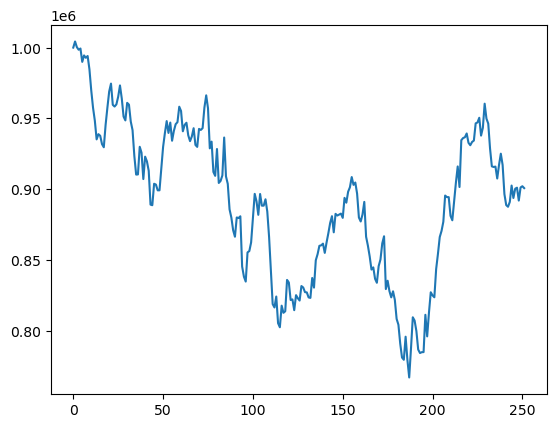

In [25]:
%matplotlib inline
df_account_value.account_value.plot()

In [26]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
print(perf_stats_all)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.099198
Cumulative returns    -0.099198
Annual volatility      0.201491
Sharpe ratio          -0.419975
Calmar ratio          -0.420042
Stability              0.202843
Max drawdown          -0.236163
Omega ratio            0.932780
Sortino ratio         -0.581923
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.022327
Daily value at risk   -0.025721
dtype: float64


In [27]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


In [28]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.004319e+06
2022-01-05  1.000320e+06
2022-01-06  9.984907e+05
2022-01-07  9.993466e+05
...                  ...
2022-12-27  9.011052e+05
2022-12-28  8.920279e+05
2022-12-29  9.012886e+05
2022-12-30  9.021371e+05
2023-01-03  9.008016e+05

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.004319e+06  1.005866e+06
2022-01-05  1.000320e+06  9.951360e+05
2022-01-06  9.984907e+05  9.904718e+05
2022-01-07  9.993466e+05  9.903404e+05
...       

<AxesSubplot: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

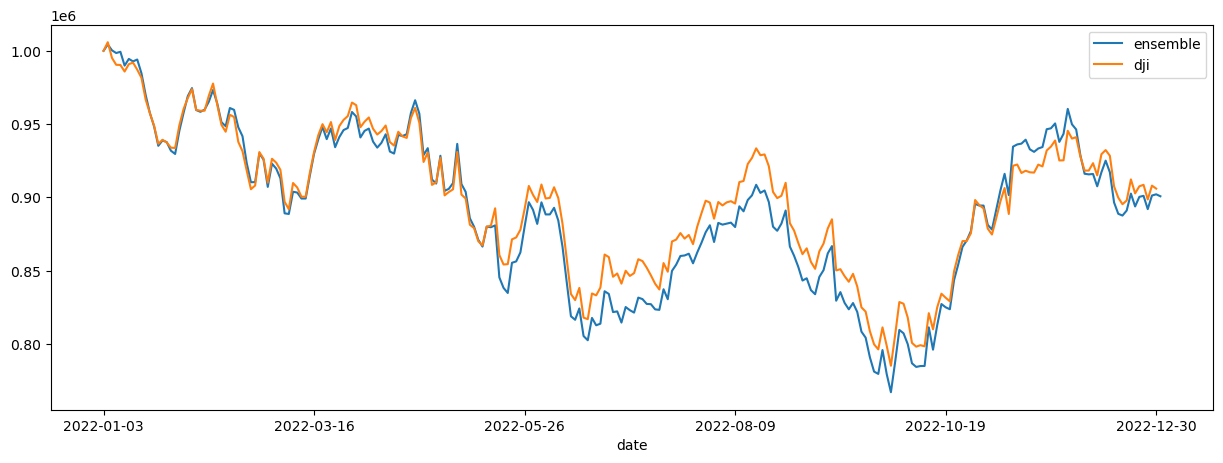

In [29]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()